# Constrastive Learning Using SimCLR (Siamese Architecture) with UNet as a backbone

In [ ]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-03-17 14:21:49--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  13.7MB/s    in 3.7s    

2025-03-17 14:21:54 (13.7 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-03-17 14:21:54--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  8.02MB/s    in 1.5s    

2025-03-17 14:21:56 (8.02 

In [ ]:
!unzip train-images.zip
!unzip test-images.zip

Archive:  train-images.zip
   creating: train-images/
  inflating: train-images/348.png    
  inflating: train-images/1804.png   
 extracting: train-images/1810.png   
 extracting: train-images/1186.png   
 extracting: train-images/412.png    
 extracting: train-images/374.png    
  inflating: train-images/1838.png   
 extracting: train-images/360.png    
 extracting: train-images/406.png    
  inflating: train-images/1192.png   
 extracting: train-images/1179.png   
 extracting: train-images/1145.png   
 extracting: train-images/1623.png   
 extracting: train-images/1637.png   
 extracting: train-images/1151.png   
 extracting: train-images/638.png    
  inflating: train-images/176.png    
 extracting: train-images/88.png     
 extracting: train-images/610.png    
 extracting: train-images/1384.png   
 extracting: train-images/1390.png   
 extracting: train-images/604.png    
  inflating: train-images/162.png    
 extracting: train-images/189.png    
 extracting: train-images/837.png 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")
    plt.show()

Our entire dataset images shape is (2000, 256, 256)
Our dataset labels shape is (800, 65536)


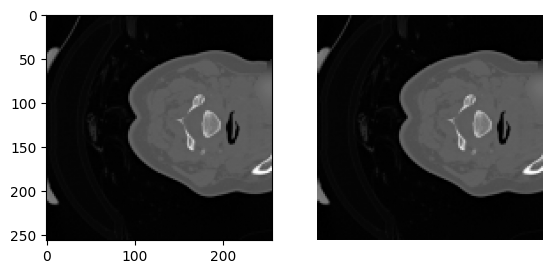

In [ ]:
labels_train  = pd.read_csv('y_train.csv', index_col=0).T.iloc[:800]

data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")


# data_train = (data_train).reshape((-1, 1, 256,256))
# data_test = (data_test).reshape((-1, 1, 256,256))
# labels_train = torch.from_numpy(labels.to_numpy()).reshape((-1, 256,256))

print(f"Our entire dataset images shape is {data_train.shape}")
print(f"Our dataset labels shape is {labels_train.shape}")
plot_slice_seg(data_train[5], labels_train.iloc[5].values)

## Transformations for the constrastive learning

In [ ]:
import torchvision
from torchvision import transforms
from PIL import Image

class ContrastiveTransformations:
    def __init__(self, img_size):
        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),  # Convert numpy to tensor (handles grayscale)
        #     transforms.Resize((img_size, img_size)),  # Resize to fixed dimensions
        #     transforms.RandomHorizontalFlip(),  # Flip left-right
        #     transforms.RandomRotation(degrees=10),  # Small rotations
        #     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
        #     transforms.GaussianBlur(kernel_size=3),  # Slight blurring
        #     transforms.Normalize(mean=data_train.mean(), std=data_train.std()),  # Normalize HU values
        # ])

        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert numpy to tensor
            #transforms.Resize((img_size, img_size)),  # Resize to fixed dimensions
            transforms.RandomHorizontalFlip(p=0.5),  # Flip left-right (50% probability)
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small rotations and translations
            #transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),  # Random cropping and resizing
            transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),  # Slight blurring
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5)], p=0.7),  # Adjust brightness/contrast
            #transforms.Normalize(mean=data_train.mean(), std=data_train.std()),  # Normalize intensity values
        ])

    def __call__(self, x):
      # it outputs a tuple, namely 2 views (augmentations) for the same image
      x = Image.fromarray(x)
      return  (self.transform(x), self.transform(x))

In [ ]:
from torch.utils.data import Dataset

class CTSCANDataset(Dataset):
    def __init__(self, X, transform=None, contrastive=True):
        self.X = X
        self.transform = transform
        self.contrastive = contrastive


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]

        if self.contrastive :
            view1, view2 = self.transform(x)  # Apply any transformation (if needed)
            return view1, view2
        else :
            return self.transform(x)


# Create dataset
dataset_2viewsCon = CTSCANDataset(np.concatenate((data_train, data_test)), transform=ContrastiveTransformations(256))
dataset_train = CTSCANDataset(data_train, transform=transforms.Compose([transforms.ToTensor()]), contrastive=False)
dataset_test = CTSCANDataset(data_test, transform=transforms.Compose([transforms.ToTensor()]), contrastive=False)

# Example usage
print(dataset_2viewsCon[0][0].shape)# First sample
print(dataset_train[0].shape)# First sample


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
def imshowCTSCAN2views(datasetOrig,datasetTransform,rows=5,figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3*(rows-1)+2,3):
      imgOrig = datasetOrig[i].numpy()
      img1=datasetTransform[i][0].numpy()
      img2=datasetTransform[i][1].numpy()

      fig.add_subplot(rows, 3, i)
      plt.title( 'original')
      plt.imshow(np.transpose(imgOrig, (1, 2, 0)), cmap='gray')
      plt.axis("off")
      fig.add_subplot(rows, 3, i+1)
      plt.title( '1st view')
      plt.imshow(np.transpose(img1, (1, 2, 0)), cmap='gray')
      plt.axis("off")
      fig.add_subplot(rows, 3, i+2)
      plt.title( '2nd view')
      plt.imshow(np.transpose(img2, (1, 2, 0)), cmap='gray')
      plt.axis("off")
    plt.show()

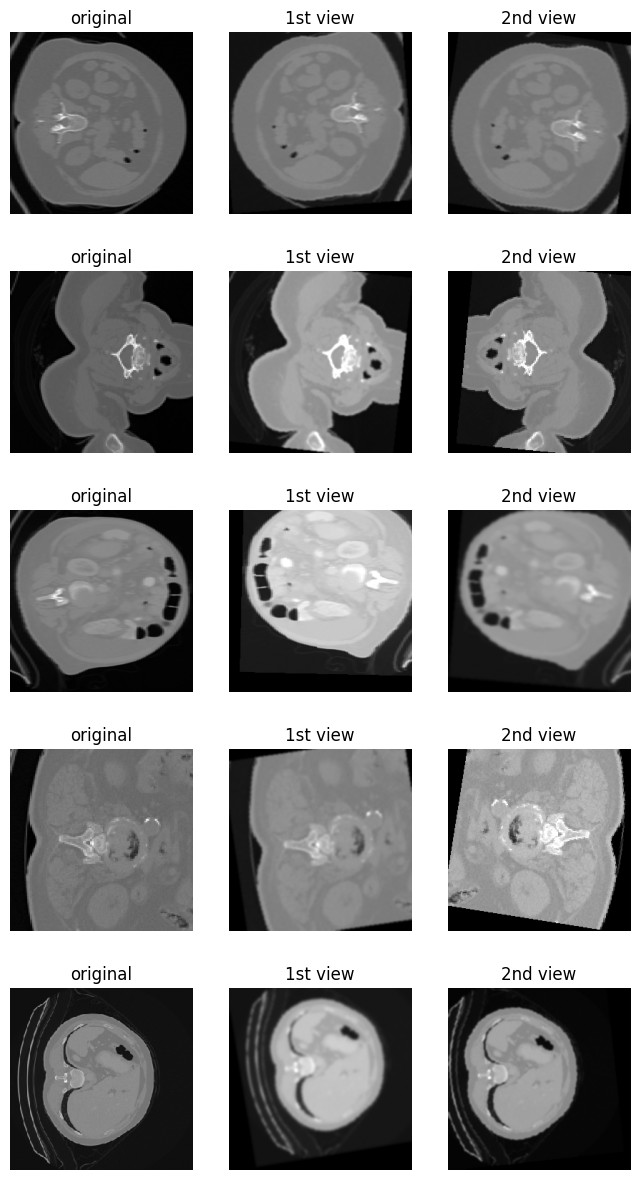

In [ ]:
imshowCTSCAN2views(dataset_train,dataset_2viewsCon)

## SIMCLR ARCHITECTURE

In [ ]:

import shutil
import yaml
import logging
import os
import sys

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

torch.manual_seed(0)
dir_checkpoint = Path('checkpoints_SimCLR')

class SimCLR():

    def __init__(self, model, optimizer, scheduler, device, batch_size, temperature, epochs):
        self.device=device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.temperature=temperature
        self.batch_size=batch_size
        self.epochs=epochs

    def info_nce_loss(self, features):
        ## This function i took from some friend of mine since i struggled with my connexion and didn't have enough time
        z_i = features[:self.batch_size, :]
        z_j = features[self.batch_size:, :]

        cos_sim = F.cosine_similarity(features[:,None,:], features[None,:,:], dim=-1)

        # Mask out the positive samples
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        cos_sim = cos_sim / self.temperature
        loss = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        loss = loss.mean()

        return loss

    def train(self, train_loader, save_checkpoint = True, swin=False):

        scaler = GradScaler() # gradient scaling, useful when we use float16

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        for epoch_counter in range(self.epochs):
            self.model.train()
            total_loss = 0.0
            num_batches = 0
            for images in tqdm(train_loader):

                images = torch.cat([images[0], images[1]], dim=0)
                images = images.to(self.device)

                self.optimizer.zero_grad()
                with autocast(dtype=torch.float16): # to improve performance while maintaining accuracy.
                # #with autocast():
                  features = self.model(images)
                  loss = self.info_nce_loss(features)
                scaler.scale(loss).backward() # to improve performance while maintaining accuracy.
                #loss.backward()
                scaler.step(self.optimizer) # to improve performance while maintaining accuracy.
                #self.optimizer.step()
                scaler.update()
                total_loss += loss.item()
                num_batches += 1
                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()

            if save_checkpoint:
                Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
                state_dict = model.state_dict()
                if swin :
                    torch.save(model.encoder.swinViT.state_dict(), str(dir_checkpoint / 'swin_simclr_encoder_epoch{}.pth'.format(epoch_counter)))
                else :
                    torch.save(model.encoder.state_dict(), str(dir_checkpoint / 'simclr_encoder_epoch{}.pth'.format(epoch_counter)))
            avg_loss = total_loss / num_batches
            print('Epoch: {}, Average loss: {:.4f}, lr: {:.4f}'.format(epoch_counter, avg_loss, self.scheduler.get_last_lr()[0]))

        print("Training has finished.")

In [ ]:
bs = 16 # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(dataset=dataset_2viewsCon, batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)

In [ ]:
class Projection_head(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Projection_head, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = self.l1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = self.bn2(x)
        return x

In [ ]:
! pip install monai

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# PINGU PINGU PINGU!!!! O Macron é um bosta

class conv_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward (self, x) :
        x = self.conv(x)
        p = self.pool(x)
        return x,p

class decoder_block(nn.Module) :
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = conv_block(out_channels + out_channels, out_channels)

    def forward(self, x, skip) :
        x = self.pool(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class UNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.enc1 = encoder_block(in_channels, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)


    def forward(self, x):
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4, p4 = self.enc4(p3)

        return x1, x2, x3, x4, p4  # Return features at different levels

class UNET(nn.Module) :
    def __init__(self, in_channels, nb_classes, train_SSL = True):
        super().__init__()

        ## Encoder
        self.encoder = UNetEncoder(in_channels)

        #Bottelneck
        self.b = conv_block(512, 1024)

        ## Decoder
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)

        #Classifier
        self.classifier = nn.Conv2d(64, nb_classes, kernel_size=1)

    def forward(self, x) :

        x1, x2, x3, x4, p4 = self.encoder(x)

        x = self.b(p4)

        y1 = self.dec1(x, x4)
        y2 = self.dec2(y1, x3)
        y3 = self.dec3(y2, x2)
        y4 = self.dec4(y3, x1)

        out = self.classifier(y4)

        return out

class UNetSimCLR(nn.Module):
    def __init__(self, in_channels, g_dim):
        super().__init__()
        self.encoder = UNetEncoder(in_channels, train_SSL=True)
        self.projection_head = Projection_head(512, 512, g_dim)  # Adjust dims

    def forward(self, x):
        _, _, _, _, features = self.encoder(x)  # (B, 512, H, W)
        pooled = F.adaptive_avg_pool2d(features, (1, 1))  # (B, 512, 1, 1)
        flattened = pooled.view(pooled.shape[0], -1)  # (B, 512)
        return self.projection_head(flattened)  # (B, g_dim)

from monai.networks.nets import SwinUNETR

class SwinUNetSimCLR(nn.Module):
    def __init__(self, in_channels, g_dim):
        super().__init__()

        self.encoder = SwinUNETR(img_size=(256, 256), in_channels=in_channels, out_channels=55, feature_size=48, spatial_dims=2)
        self.projection_head = Projection_head(768, 768, g_dim)  # Adjust dims

    def forward(self, x):
        features = self.encoder.swinViT(x)  # (B, 768, H, W)
        pooled = F.adaptive_avg_pool2d(features[-1], (1, 1))  # (B, 768, 1, 1)
        flattened = pooled.view(pooled.shape[0], -1)  # (B, 768)
        return self.projection_head(flattened)  # (B, g_dim)

In [ ]:
max_epochs=50
lr=3e-2
wd=1e-4
temperature=0.07
#f_dim=512 # to use if you want to change the output dimension of f
g_dim=128 # the output dimension of the projection head

# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

model = SwinUNetSimCLR(1, g_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1)

simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, device=device, batch_size=bs, temperature=temperature, epochs=max_epochs)
simclr.train(train_unlabelled_loader, swin=True)

Device: cuda:0


<ipython-input-14-6b45438995b0>:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # gradient scaling, useful when we use float16


Start SimCLR training for 50 epochs.


  0%|          | 0/156 [00:00<?, ?it/s]<ipython-input-14-6b45438995b0>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16): # to improve performance while maintaining accuracy.
100%|██████████| 156/156 [02:15<00:00,  1.15it/s]


Epoch: 0, Average loss: 5.2898, lr: 0.0300


100%|██████████| 156/156 [02:05<00:00,  1.24it/s]


Epoch: 1, Average loss: 3.4348, lr: 0.0300


100%|██████████| 156/156 [02:05<00:00,  1.25it/s]


Epoch: 2, Average loss: nan, lr: 0.0300


100%|██████████| 156/156 [02:06<00:00,  1.23it/s]


Epoch: 3, Average loss: nan, lr: 0.0300


100%|██████████| 156/156 [02:06<00:00,  1.24it/s]


Epoch: 4, Average loss: nan, lr: 0.0300


 85%|████████▌ | 133/156 [01:48<00:18,  1.23it/s]


KeyboardInterrupt: 